## Head <a name="head"></a>

In [1]:
import pandas as pd
import numpy as np
import pickle 
import datetime

import itertools
from itertools import product
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

from utils import tsplot, invboxcox
from ts_stat_tests import ks_2s_test, ljungboxtest

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import fbprophet

import greykite
import greykite.common.constants as cst
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from datetime import datetime, timedelta
from greykite.common.data_loader import DataLoader
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum 
from greykite.framework.utils.result_summary import summarize_grid_search_results
from greykite.algo.changepoint.adalasso.changepoint_detector import ChangepointDetector
import plotly
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.6f}'.format)


## Load'n'cook <a name="loadncook"></a>

## Load <a name="load"></a>

In [2]:
tmp = pd.read_csv('parsed_data.csv')
tmp.columns = ['year', 'month', 'kbk_code', 'sb', 'rb', 'lb']

## Cook <a name="load"></a>

In [3]:
month_dict = {
    "январь": 1,
    "февраль": 2,
    "март": 3,
    "апрель": 4,
    "май": 5,
    "июнь": 6,
    "июль": 7,
    "август": 8,
    "сентябрь": 9,
    "октябрь": 10,
    "ноябрь": 11,
    "декабрь": 12
}

# with a change in legislation, the budget classification code could change
kbk_dict = {
    '101101': '101110',
    '101102': '101110',
    '101103': '101110',
    '101104': '101110',
    '101110': '101110'

}

tmp['kbk_code'] = tmp['kbk_code'].apply(lambda x: str(x))
tmp['month'] = tmp['month'].apply(lambda x: str(x).strip())
tmp['month'] = tmp['month'].map(month_dict)
tmp = tmp.sort_values(by=['kbk_code', 'year', 'month'], ascending = (True, True, True))

tmp = tmp.query('year >= 2009')
tmp['kbk_code_new'] = tmp['kbk_code'].map(kbk_dict)
tmp['rb'] = tmp['rb'].astype(float)
_tmp = tmp.query('kbk_code_new == "101110"')

In [4]:
df = pd.DataFrame()

array_of_year = np.unique(tmp['year'])

# tax receipts are indicated not for the period, but cumulatively as of the date
for year in array_of_year:
    __tmp = _tmp.query('year == @year')
    __tmp['amount'] = (_tmp['rb'] - _tmp['rb'].shift(1))
    __tmp.loc[__tmp['month'] == 1, 'amount'] = __tmp['rb']
    #tmp['amount'].fillna(tmp['rb'], inplace = True)
    __tmp['amount'] = __tmp['amount']*1000
    df = df.append(__tmp)
    
df['ds'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + '01'
df['ds'] = pd.to_datetime(df['ds'])

columns_ordered = ['ds', 'year', 'month', 'kbk_code_new', 'amount']

df = df[columns_ordered]
df = df.groupby(['ds', 'year', 'month'], as_index = False).agg({'amount': 'sum'})

# the website lacks data for October 2019 and November 2019 
# The data was requested from the State Revenue Office of the Ministry of Finance of the Republic of Kazakhstan
october_data = [['2019-10-01', 2019, 10, 127347435814]]
october_data = pd.DataFrame(october_data, columns = df.columns)
october_data['ds'] = pd.to_datetime(october_data['ds'])

df = df.append(october_data)
df.loc[df['ds'] == "2019-11-01", 'amount'] = 188544740679
df = df.sort_values(by=['ds'], ascending = True) \
       .reset_index(drop = True) \
       .rename(columns={'amount': 'y'})

df.head()

,ds,year,month,y
0,2009-01-01,2009,1,68915876000.000000
1,2009-02-01,2009,2,60210075000.000000
2,2009-03-01,2009,3,65476422000.000000
3,2009-04-01,2009,4,37704039000.000000
4,2009-05-01,2009,5,20508038000.000000


In [5]:
train_date_start = '2011-01-01'
train_date_end = '2018-12-01'
test_date_start = '2019-01-01'
test_date_end = '2019-12-01'

train_df = df.query('ds >= @train_date_start and ds <= @train_date_end')
test_df = df.query('ds >= @test_date_start and ds <= @test_date_end')

## EDA <a name="eda"></a>

### Dispersion analysis <a name="dispersion"></a>

In [6]:
train_df \
    .query('y <= 0') 

,ds,year,month,y


In [7]:
ks_2s_test(0.05, train_df['y'], test_df['y'])

Null hypothesis is rejected with D=0.6354166666666666, p=0.00013371527222161284 for a=0.05
The distributions differ


(0.6354166666666666, 0.00013371527222161284, 0.4158319665581168)

In [8]:
y = train_df.y.values
split = round(len(y) / 2)
y1, y2 = y[0:split], y[split:]
mean1, mean2 = y1.mean(), y2.mean()
var1, var2 = y1.var(), y2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=89458339354.166672, mean2=121809543937.500000
variance1=1575218456995795566592.000000, variance2=5344724687834895613952.000000


Dickey-Fuller criteria: p=0.958632
Box-cox transformation optimal parameter: -0.012968


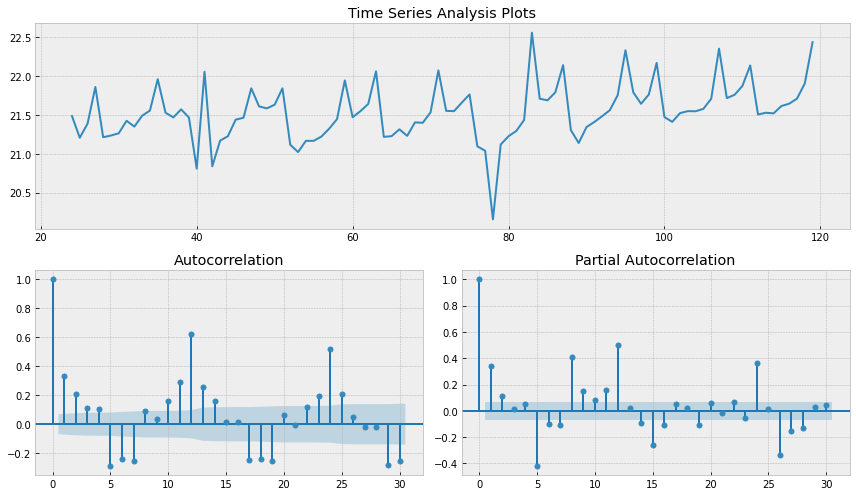

In [9]:
train_df['y_box'], lmbda = scs.boxcox(train_df.y) 
tsplot(train_df.y_box, lags=30)
print("Box-cox transformation optimal parameter: %f" % lmbda)

In [10]:
y_1 = train_df.y_box.values
split = round(len(y_1) / 2)
y1, y2 = y_1[0:split], y_1[split:]

mean1, mean2 = y1.mean(), y2.mean()
var1, var2 = y1.var(), y2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=21.446390, mean2=21.622092
variance1=0.085029, variance2=0.158879


In [11]:
train_df.head()

,ds,year,month,y,y_box
24,2011-01-01,2011,1,86379906000.000000,21.483467
25,2011-02-01,2011,2,58782444000.000000,21.205100
26,2011-03-01,2011,3,75513724000.000000,21.386398
27,2011-04-01,2011,4,145378148000.000000,21.857746
28,2011-05-01,2011,5,59314415000.000000,21.211632


## ARIMA <a name="arima"></a>

### First approach <a name="first_approach"></a>

In [12]:
first_model = sm.tsa.statespace.SARIMAX(train_df.y_box, order=(0, 1, 0), 
                                        seasonal_order=(0, 1, 0, 12)).fit(disp=-1)

### ACF/PACF <a name="acf_pacf"></a>

Dickey-Fuller criteria: p=0.006162


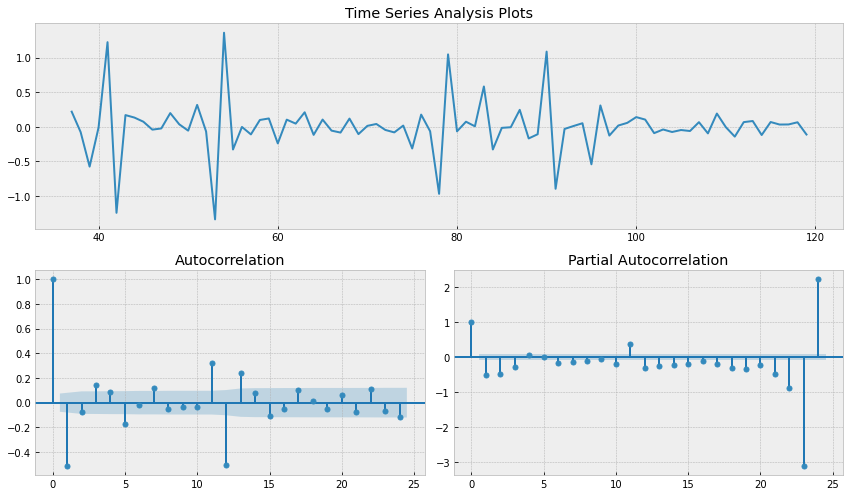

In [13]:
tsplot(first_model.resid[13:], lags=24)

### Parameters grid <a name="arima_tuning"></a>

In [14]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)


parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [15]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    # try except because on some sets of parameters the model is not trained
    try:
        model=sm.tsa.statespace.SARIMAX(train_df.y_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    # we display the parameters on which the model is not trained and go to the next set
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|          | 0/100 [00:00<?, ?it/s]

      parameters      aic
12  (0, 2, 2, 0) 5.110914
27  (1, 1, 2, 0) 5.146239
7   (0, 1, 2, 0) 5.148056
9   (0, 1, 4, 0) 5.322794
57  (2, 3, 2, 0) 6.467851
Wall time: 1min 52s


In [16]:
%%time
best_model = sm.tsa.statespace.SARIMAX(train_df.y_box, order=(0, d, 2), 
                                        seasonal_order=(2, D, 0, 12)).fit(disp=-1)
print(best_model.summary())  

                                      SARIMAX Results                                      
Dep. Variable:                               y_box   No. Observations:                   96
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 12)   Log Likelihood                   2.445
Date:                             Tue, 02 Nov 2021   AIC                              5.111
Time:                                     20:50:44   BIC                             17.205
Sample:                                          0   HQIC                             9.970
                                              - 96                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7112      0.083     -8.565      0.000      -0.874      -0.548
ma.L2         -0.1696      

Dickey-Fuller criteria: p=0.000000


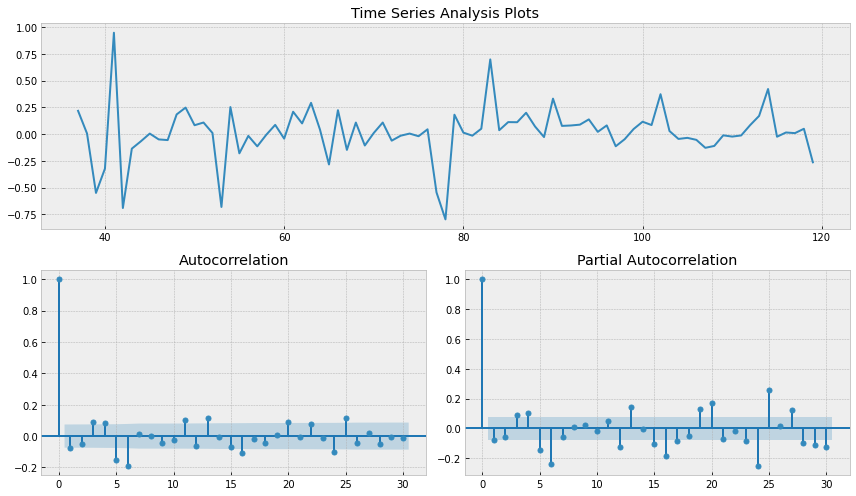

In [17]:
tsplot(best_model.resid[13:], lags=30)

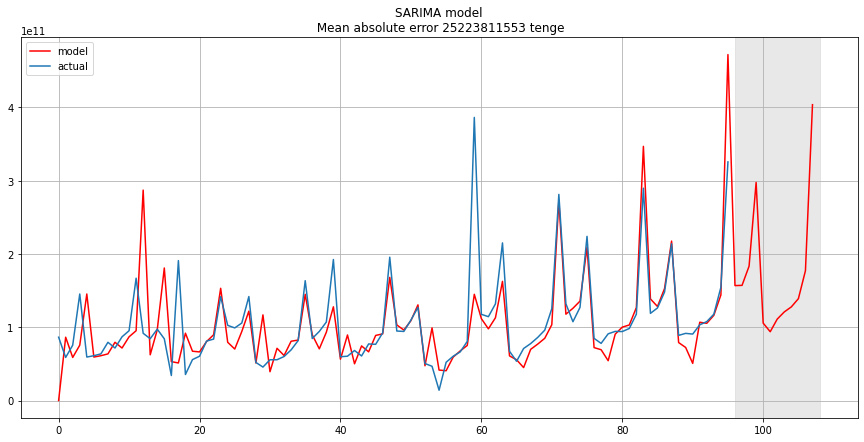

In [18]:
tt = train_df.copy()
tt['arima_model']  = invboxcox(best_model.fittedvalues, lmbda)
# minor error
tt.loc[tt['ds'] == '2012-01-01', 'arima_model'] = 287175712124.28
forecast = invboxcox(best_model.predict(start = tt.shape[0], end = tt.shape[0]+11), lmbda)
forecast = tt.arima_model.append(forecast).values
actual = tt.y.values[-96:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} tenge".format(round(mean_absolute_error(tt.dropna().y, tt.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [19]:
test_df['arima_forecast'] = forecast[96:]
test_df['arima_residuals'] = test_df['y'] - test_df['arima_forecast']

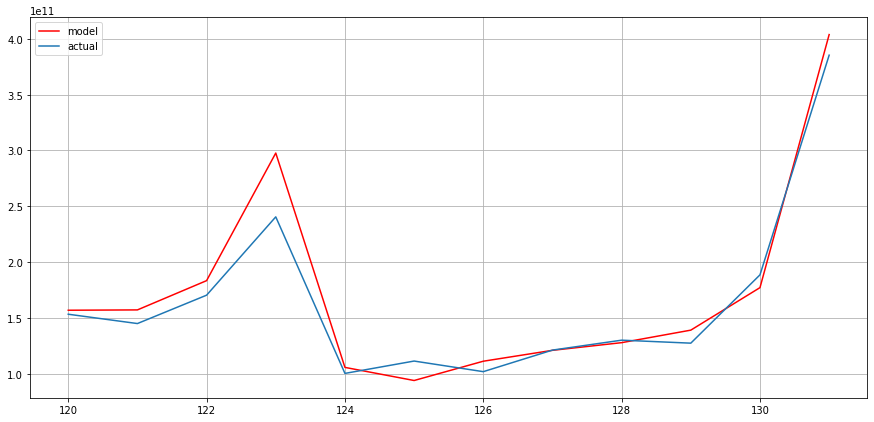

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(test_df['arima_forecast'], color='r', label="model")
plt.plot(test_df['y'], label="actual")
plt.legend()
plt.grid(True)

In [21]:
arima_mape = mean_absolute_percentage_error(test_df['y'], test_df['arima_forecast'])
arima_mape

7.859053920528515

In [22]:
r2_score_arima = r2_score(test_df['y'], test_df['arima_forecast'])
r2_score_arima

0.9347523812056596

In [23]:
arima_lbvalue, arima_lb_pvalue = ljungboxtest(0.05, np.array(test_df['arima_residuals']))

Null hypothesis is not rejected with Ljung-Box test statistic = 0.0076327216498091694, p = 0.9303810321728011 for a = 0.05
There is no autocorrelation in residuals


## fbprophet <a name="fbprophet"></a>

In [24]:
path_images = f'images/fbprophet/model_report'
path_models = f'models/fbprophet'

if not os.path.exists(path_images):
    os.makedirs(path_images)
if not os.path.exists(path_models):
    os.makedirs(path_models)

In [25]:
def make_model(data: pd.DataFrame,
               train_date_start: str, 
               train_date_end: str,
               forecast_date_begin: str,
               forecast_date_end: str,
               version: str = '1', 
               use_transformed_target: bool = False,
               ignore_deval = True,
               clean_outliers: bool = False,
               save_model: bool = True, 
               save_graphs: bool = True) -> pd.DataFrame:
    '''
    The main method to build a prophet model
    Args:
        data - dataframe 
        use_transformed_target
        train_date_start - left bound for dataframe
        train_date_start - right bound for dataframe
        forecast_date_begin - left bound of future dataframe
        forecast_date_end - left bound of future dataframe
        version - unique identifier for the model. Required for version control
        use_transformed_target - use either y or y_box
        clean_outliers - remove observations that fall outside the 99% confidence interval (3 standard deviations)
        save_model - save model for future use (saved in pkl format)
        save_graphs - save model graphs
    Returns:
        result - dataframe with actual and forecasted values
    '''
    
    df = data.copy()
    # filter the dataset within the dates of the training sample
    df = df.query('ds >= @train_date_start and ds <= @train_date_end', engine = 'python')

    # renaming the fields according to fbprophet requirements
    if use_transformed_target:
        df = df[['ds','y_box']]
    else:
        df = df[['ds', 'y']]
    
    
    df.columns = ['ds', 'y']
    df['forecast'] = '0'

    # remove records that are out of 3 standard deviations from the expected value
    if clean_outliers:
        upper_bound = df.y.mean() + 3*df.y.std()
        lower_bound = df.y.mean() - 3*df.y.std()
        df = df.query('(y >= @lower_bound) and (y<=@upper_bound)')
    
    if ignore_deval:
        df = df.query('ds < "2015-08-01" or ds >= "2016-01-01"')
            
        
    m = fbprophet.Prophet(yearly_seasonality=True,
            seasonality_prior_scale=0.1,
            daily_seasonality=False,
            n_changepoints=5,
            changepoint_prior_scale = 1,
            weekly_seasonality=False, 
            seasonality_mode='multiplicative',
            growth = 'linear',
            interval_width=0.95)
    
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i, month in enumerate(months):
        df[month] = (df['ds'].dt.month == i).values.astype('float')
        m.add_regressor(month)
    

    

    # fit the model
    m.fit(df)

    # create a dataset for future observations
    forecast_periods = len(pd.date_range(forecast_date_begin, forecast_date_end, freq = 'MS'))
    future = m.make_future_dataframe(periods = forecast_periods, freq = 'MS')
    future['forecast'] = '1'
    for i, month in enumerate(months):
        future[month] = (future['ds'].dt.month == i).values.astype('float')
    
        
    # forecasting
    forecast = m.predict(future)  
    
    result = pd.merge(df[['ds', 'y', 'forecast']], 
                      forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']], 
                      on='ds', 
                      how='outer')
    
    result['forecast'].fillna('1', inplace = True)
    result = result.rename(columns = {'yhat_lower': 'predicted_lower_bound', 'yhat_upper': 'predicted_upper_bound'})
    
      
    # save plots
    if save_graphs:
        m.plot(forecast, plot_cap=False, ylabel='forecast', xlabel='date') \
         .savefig(f'images/fbprophet/model_report/forecast_{version}.png')
        plt.close()
        m.plot_components(forecast) \
         .savefig(f'images/fbprophet/model_report/components_{version}.png')
        plt.close()

    # save model
    if save_model:
        pkl_path = f"models/fbprophet/model_{version}.pkl"
        with open(pkl_path, "wb") as f:
            pickle.dump(m, f)     
        
    return result

In [26]:
prediction = pd.DataFrame()
full_ts = pd.DataFrame()

_tmp = make_model(train_df, '2011-01-01', '2018-12-01', '2019-01-01', '2019-12-01')
#_eval = _tmp.query('forecast == "0" and y.isna() == False', engine = 'python')
_forecast = _tmp.query('forecast == "1"', engine = 'python')


prediction = prediction.append(_forecast, ignore_index = True)

full_ts = full_ts.append(_tmp, ignore_index = True)
full_ts['residuals'] = full_ts['y'] - full_ts['yhat']

columns = ['yhat', 'predicted_lower_bound', 'predicted_upper_bound']

prediction = prediction.rename(columns={'yhat': 'fbprophet_prediction'})
prediction.tail()

,ds,y,forecast,fbprophet_prediction,predicted_lower_bound,predicted_upper_bound
7,2019-08-01,NaN,1,113716149902.100281,76254399732.037918,153722865547.053406
8,2019-09-01,NaN,1,119256312522.561752,79532696874.928146,158348976524.771484
9,2019-10-01,NaN,1,131939297118.069626,89304573699.461029,171937015393.764221
10,2019-11-01,NaN,1,160495498568.252319,121263040476.512497,199891754308.062805
11,2019-12-01,NaN,1,339889495992.627563,299912447828.914917,378092461689.869141


In [27]:
cols = ['ds', 'fbprophet_prediction']

_test_df = pd.merge(test_df,
                    prediction[cols],
                    how = 'left',
                    on = ['ds'])

_test_df['fbprophet_residuals'] = _test_df['y'] - _test_df['fbprophet_prediction']
_test_df.tail()

,ds,year,month,y,arima_forecast,arima_residuals,fbprophet_prediction,fbprophet_residuals
7,2019-08-01,2019,8,121132096000.000000,120926227553.182617,205868446.817383,113716149902.100281,7415946097.899719
8,2019-09-01,2019,9,130018596000.000000,127788072747.689316,2230523252.310684,119256312522.561752,10762283477.438248
9,2019-10-01,2019,10,127347435814.000000,139013534062.932983,-11666098248.932983,131939297118.069626,-4591861304.069626
10,2019-11-01,2019,11,188544740679.000000,177100110152.821594,11444630526.178406,160495498568.252319,28049242110.747681
11,2019-12-01,2019,12,385334049000.000000,403790141909.732178,-18456092909.732178,339889495992.627563,45444553007.372437


Dickey-Fuller criteria: p=0.000000


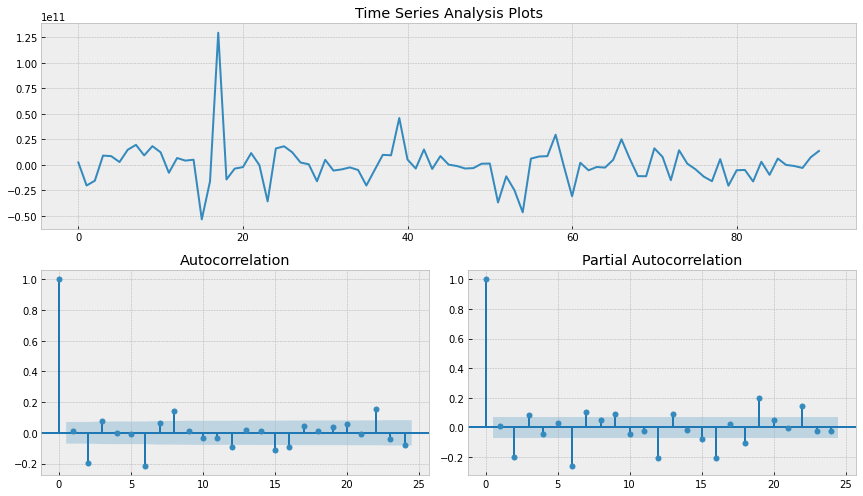

In [28]:
tsplot(full_ts.query('forecast == "0"')['residuals'], lags=24)

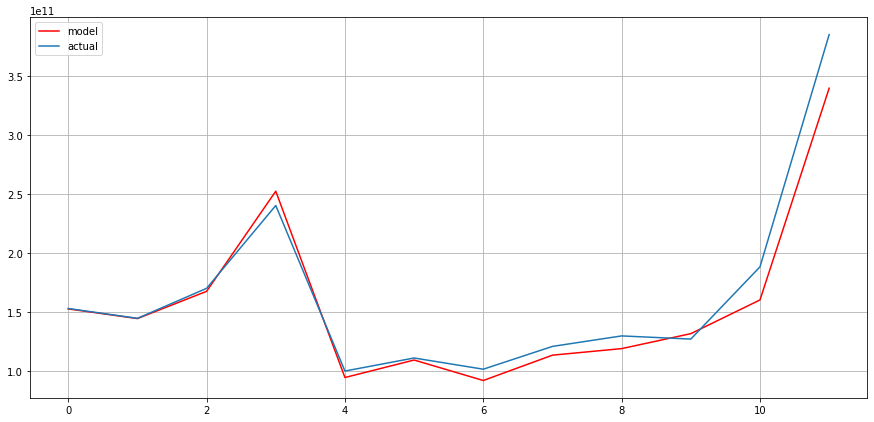

In [29]:
plt.figure(figsize=(15, 7))
plt.plot(_test_df['fbprophet_prediction'], color='r', label="model")
plt.plot(_test_df['y'], label="actual")
plt.legend()
plt.grid(True)

In [30]:
fbprophet_mape = mean_absolute_percentage_error(_test_df['y'], _test_df['fbprophet_prediction'])
fbprophet_mape

5.668240467388752

In [31]:
r2_score_prophet = r2_score(_test_df['y'], _test_df['fbprophet_prediction'])
r2_score_prophet

0.9532007979492165

In [32]:
fbp_lbvalue, fbp_pvalue = ljungboxtest(0.05, np.array(_test_df['fbprophet_residuals']))

Null hypothesis is not rejected with Ljung-Box test statistic = 1.2174237622849537, p = 0.26986683284756363 for a = 0.05
There is no autocorrelation in residuals


In [33]:
_test_df

,ds,year,month,y,arima_forecast,arima_residuals,fbprophet_prediction,fbprophet_residuals
0,2019-01-01,2019,1,153266215000.000000,156846125708.430084,-3579910708.430084,152898671796.539215,367543203.460785
1,2019-02-01,2019,2,144911380000.000000,157136663209.703644,-12225283209.703644,144721884687.901764,189495312.098236
2,2019-03-01,2019,3,170328739000.000000,183358641272.786255,-13029902272.786255,167791804869.069427,2536934130.930573
3,2019-04-01,2019,4,240492956000.000000,297656621743.121887,-57163665743.121887,252635388517.622040,-12142432517.622040
4,2019-05-01,2019,5,100255999000.000000,105643270306.157806,-5387271306.157806,94761143399.083664,5494855600.916336
5,2019-06-01,2019,6,111317861000.000000,93892621663.780853,17425239336.219147,109590625084.695404,1727235915.304596
6,2019-07-01,2019,7,101815052000.000000,111165980182.578369,-9350928182.578369,92242671872.618240,9572380127.381760
7,2019-08-01,2019,8,121132096000.000000,120926227553.182617,205868446.817383,113716149902.100281,7415946097.899719
8,2019-09-01,2019,9,130018596000.000000,127788072747.689316,2230523252.310684,119256312522.561752,10762283477.438248
9,2019-10-01,2019,10,127347435814.000000,139013534062.932983,-11666098248.932983,131939297118.069626,-4591861304.069626


### Silverkyte

In [34]:
def last_day_of_month(any_day):
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - timedelta(days=next_month.day)

In [35]:
df=df[['ds','y']]
df['ts']=df.ds.apply(lambda x: last_day_of_month(x))
df=df[['y','ts']]
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

for i, month in enumerate(months):
    df[str(month)] = (df['ts'].dt.month == i+1).values.astype('int64')

In [36]:
ts = UnivariateTimeSeries()
ts.load_data(
    df=df,
    time_col="ts",
    value_col="y",
    freq="M")

In [37]:
metadata = MetadataParam(
     time_col="ts",  # name of the time column 
     value_col="y",  # name of the value column 
     freq="M",
    train_end_date=datetime.strptime('12/31/19','%m/%d/%y')
)

In [38]:
lag_dict = dict(orders=[12,36,48])
autoreg_dict = dict(lag_dict=lag_dict)
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam

custom_model_components = ModelComponentsParam(
    seasonality = dict(
    yearly_seasonality=False,
    quarterly_seasonality=False,
    monthly_seasonality=False,  #
    weekly_seasonality=False,
    daily_seasonality=False,
),
growth = dict(growth_term="linear")  # grid search over each option
,
custom = dict(
    fit_algorithm_dict=dict(
        fit_algorithm="linear"
    )
),

regressors=dict(
    regressor_cols=['jan', 'feb', 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
),
autoregression=dict(autoreg_dict= autoreg_dict),

changepoints = dict(
    changepoints_dict=dict(
        method="uniform",
        n_changepoints=2,
        continuous_time_col="ct1",  # the default, no need to specify
        growth_func=lambda x: x,  # the default, no need to specify
    ),
),
events = dict(
    holidays_to_model_separately = [
        None],
    holiday_lookup_countries = [None]
)
)

In [39]:
forecaster = Forecaster() # Creates forecasts and stores the result
result = forecaster.run_forecast_config(  # result is also stored as `forecaster.forecast_result`.
     df=ts.df,
     config=ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         model_components_param=custom_model_components,
         forecast_horizon=12,  # forecasts 365 steps ahead
         coverage=0.95,         # 95% prediction intervals
         metadata_param=metadata
     )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [40]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

In [50]:
mean_absolute_percentage_error(silverkyte_test_df.actual,silverkyte_test_df.forecast)

3.958099068611889

In [42]:
summary = result.model[-1].summary(max_colwidth=30)
print(summary)

================================ Model Summary =================================

Number of observations: 132,   Number of features: 19
Method: Ordinary least squares
Number of nonzero features: 19

Residuals:
         Min           1Q       Median           3Q          Max
  -6.337e+10   -7.973e+09    1.067e+08    8.328e+09    1.512e+11

         Pred_col   Estimate  Std. Err    t value Pr(>|t|) sig. code                    95%CI
        Intercept  1.302e+10 3.001e-13  4.339e+22   <2e-16       ***   (1.302e+10, 1.302e+10)
              jan  3.591e+09 3.841e-14  9.348e+22   <2e-16       ***   (3.591e+09, 3.591e+09)
              feb -1.851e+09 3.993e-14 -4.636e+22   <2e-16       *** (-1.851e+09, -1.851e+09)
              mar  7.160e+09 2.101e-14  3.408e+23   <2e-16       ***   (7.160e+09, 7.160e+09)
              apr  3.917e+10 7.851e-14  4.989e+23   <2e-16       ***   (3.917e+10, 3.917e+10)
              may -2.486e+10 6.500e-14 -3.824e+23   <2e-16       *** (-2.486e+10, -2.486e+10)
 

In [43]:
silverkyte_test_df=backtest.df.query('"2019-01-01"<ts<"2020-01-01"')
_test_df['silverkyte_forecast']=np.array(silverkyte_test_df['forecast'])
_test_df['silverkyte_residuals'] = np.array(silverkyte_test_df['actual'] - silverkyte_test_df['forecast'])

In [44]:
r2_score_silverkyte=r2_score(silverkyte_test_df['actual'],silverkyte_test_df['forecast'])
silverkyte_mape=mean_absolute_percentage_error(silverkyte_test_df['actual'],silverkyte_test_df['forecast'])
silverkyte_lbvalue, silverkyte_pvalue = ljungboxtest(0.05, np.array(_test_df['silverkyte_residuals']))

Null hypothesis is not rejected with Ljung-Box test statistic = 0.0958349845054339, p = 0.7568862535321844 for a = 0.05
There is no autocorrelation in residuals


###  Results

In [45]:
metrics_df = pd.DataFrame(columns = ['model_name', 'MAPE', 'R2', 'q_test', 'q_test_pvalue'])
arima_metrics = pd.DataFrame([['arima', arima_mape, r2_score_arima, arima_lbvalue, arima_lb_pvalue]], 
                              columns = metrics_df.columns)
fbprophet_metrics = pd.DataFrame([['fbprophet', fbprophet_mape, r2_score_prophet, fbp_lbvalue, fbp_pvalue]], 
                                   columns = metrics_df.columns)
silverkyte_metrics = pd.DataFrame([['silverkyte', silverkyte_mape, r2_score_silverkyte, silverkyte_lbvalue, silverkyte_pvalue]], 
                                   columns = metrics_df.columns)

list_of_dfs = [arima_metrics, fbprophet_metrics,silverkyte_metrics]

for df in list_of_dfs:
    metrics_df = metrics_df.append(df)
    
metrics_df

,model_name,MAPE,R2,q_test,q_test_pvalue
0,arima,7.859054,0.934752,0.007633,0.930381
0,fbprophet,5.668240,0.953201,1.217424,0.269867
0,silverkyte,3.958099,0.984828,0.095835,0.756886


In [47]:
metrics_df.to_csv('METRICS.csv',index=False)

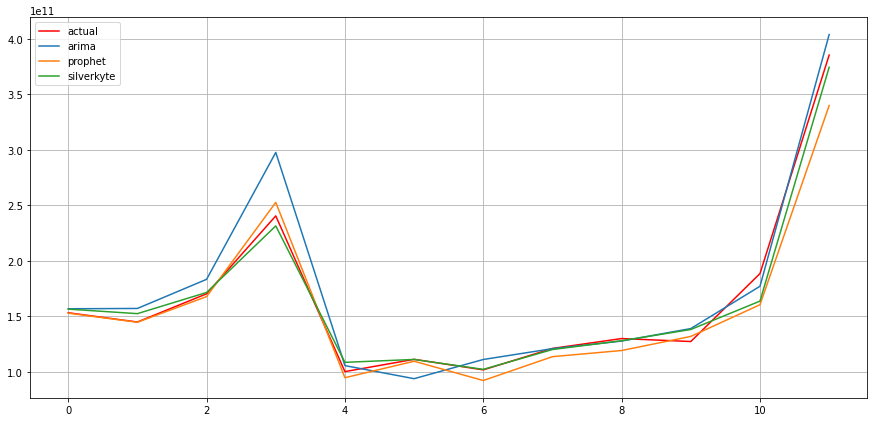

In [46]:
plt.figure(figsize=(15, 7))
plt.plot(_test_df['y'], color='r', label="actual")
plt.plot(_test_df['arima_forecast'], label="arima")
plt.plot(_test_df['fbprophet_prediction'], label="prophet")
plt.plot(_test_df['silverkyte_forecast'], label="silverkyte")

plt.legend()
plt.grid(True)